In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
!pip install flappy-bird-gym


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.1/558.1 kB 13.9 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 58.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 4.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.6 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 33.5 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657506 sha256=c88d64c25eeb78041079f8d7affb23dc7d4532c6dbade4dd88c6dbeda8163a32
  Stored in directory: /home/pedro/.cache/pip/wheels/82/21/bb/ae3f56a7f

In [71]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import os, sys
import numpy as np
from tqdm import tqdm
import logging
from gym.wrappers import RecordVideo
import text_flappy_bird_gym
from collections import defaultdict
from IPython.display import clear_output
from copy import deepcopy

import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.Agent import DQAgent, QAgent, SarsaAgent

In [3]:
!mkdir logs
logging.basicConfig(filename='logs/flappy-bird.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Flappy-Bird problem

State : 

* Observations : Distance from pipe (dx,dy)
* Actions : 2 (jump or nothing)

In [4]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()


In [5]:
next_state, reward, done, truncated, info = env.step(1)

In [6]:
next_state

(12, 1)

In [7]:
sys.stdout.write(env.render())

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=1)


579

## Agent class

In [18]:
episodes = 100000
history = {
    "Q-Learning":[],
    "SARSA": []
}

agents = {
    "Q-Learning": QAgent(2, gamma= 1),
    "SARSA": SarsaAgent(2, gamma=1)
}

for agent_name, agent in agents.items():
    for e in tqdm(range(episodes)):

        state, _ = env.reset()
        count = 0
        # Play the game!
        while True:
            count += 1
            # Run agent on the state
            
            action = agent.act(state)

            # Agent performs action
            next_state, reward, done, trunc, info = env.step(action)


            next_action = agent.act(next_state)

            # Learn
            agent.learn(state,
                        next_state,
                        action,
                        reward,
                        next_action)

            # Update state
            state = next_state

            # Check if end of game
            if done or trunc:
                history[agent_name].append(info['score'])
                # logging.info(f"Game ended")
                count = 0
                break

100%|██████████| 100000/100000 [02:13<00:00, 746.77it/s]


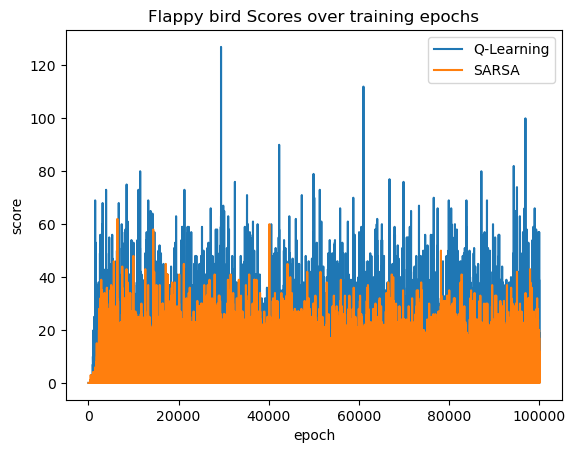

In [21]:
for model_name in history.keys():
    plt.plot(history[model_name],
             label = model_name)

plt.legend()
plt.title("Flappy bird Scores over training epochs")
plt.xlabel("epoch")
plt.ylabel("score")
plt.savefig("img/flappy_bird_TD.png")

In [ ]:
history_test = {
    "Q-Learning":[],
    "SARSA": [],
    "DQN": []
}

In [80]:

n_epochs = 1000

history_test['Q-Learning'] = []
history_test['SARSA'] = []

for name, agent in agents.items():
    for i in range(n_epochs):
        state, info = env.reset()
        while True:

            # Select next action
            agent.epsilon = 0
            action = agent.act(state)  # for an agent, action = agent.policy(observation)

            # Appy action and return new observation of the environment
            state, reward, done, _, info = env.step(action)

            # Render the game
            # clear_output(wait= True)
            # sys.stdout.write(env.render())
            # time.sleep(0.15) # FPS

            # If player is dead break
            if done or info['score']> 100:
                history_test[name].append(info['score'])
                break

            env.close()


In [34]:
episodes = 200
history_dqn = []
best_score = 0
best_model = None
dq_agent = DQAgent(2,2, "cpu", )
for e in tqdm(range(episodes)):

    state, _ = env.reset()
    # Play the game!
    while True:
        # Run agent on the state
        
        action = dq_agent.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        if info['score'] >100:
            done = True
        
        if done or trunc:
            next_state = None
        # Remember
        dq_agent.save_to_memory(state, next_state, action, reward,)

        # Learn
        loss = dq_agent.learn()

        # # Loggings
        # logging.info(loss)

        dq_agent.update_networks()

        # Update state
        state = next_state

        if info['score']>= best_score:
            best_score = info['score']
            best_model = deepcopy(dq_agent.policy_dqn)

        # Check if end of game

        if done or trunc:
            history_dqn.append(info['score'])
            logging.info(f"Game ended. Score = {info['score']}")
            count = 0
            break

dq_agent.policy_dqn = best_model

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:47<00:00,  1.20it/s]


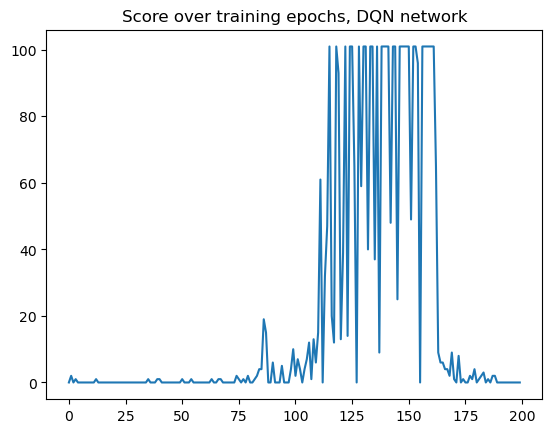

In [108]:
plt.plot(history_dqn)
plt.title("Score over training epochs, DQN network")
plt.savefig("dqn_train.png")

In [98]:
dq_agent.epsilon = 0
dq_agent.final_epsilon = 0
n_epochs = 1

for i in tqdm(range(n_epochs)):

    state, info = env.reset()
        
    while True:

        # Select next action
        
        action = dq_agent.act(state)  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        state, reward, done, _, info = env.step(action)

        # Render the game
        clear_output(wait= True)
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done or info['score']>=100:
            history_test['DQN'].append(info['score'])
            break

        env.close()


  0%|          | 0/1 [00:55<?, ?it/s]

Text Flappy Bird!
Score: 26
----------------------
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[      @             ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=3,dy=-2)


KeyboardInterrupt: 

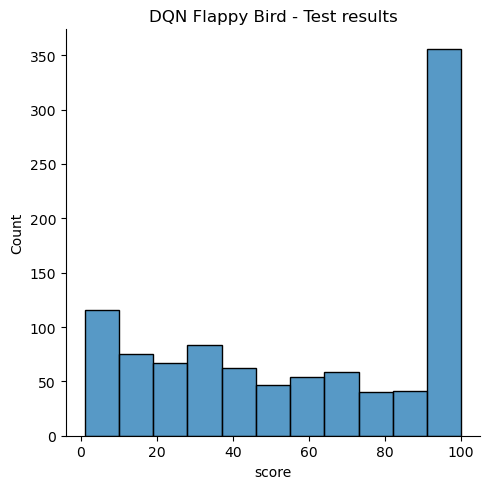

In [75]:
sns.displot(history_test['DQN'],)
plt.title("DQN Flappy Bird - Test results")
plt.xlabel("score")
plt.tight_layout()
plt.savefig("img/dqn_test.png")

In [67]:
history_test['SARSA']

[7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,


In [81]:
pd.DataFrame(history_test)

,Q-Learning,SARSA,DQN
0,0,0,2
1,11,7,36
2,2,4,100
3,11,0,75
4,31,8,100
...,...,...,...
995,0,5,13
996,6,1,100
997,17,3,40
998,28,3,67


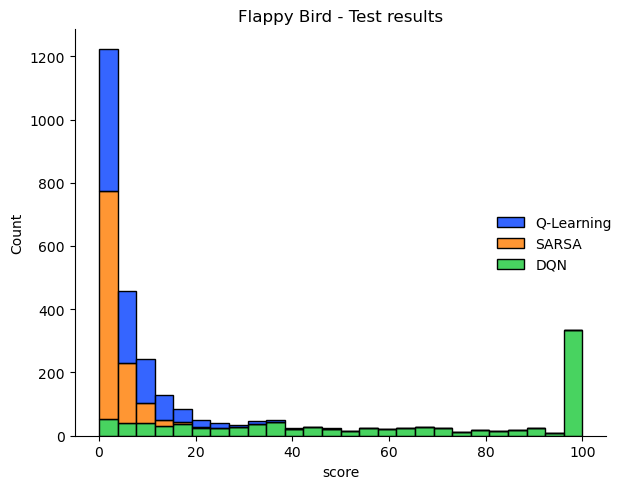

In [107]:
sns.displot(history_test, 
            palette="bright",
            alpha=0.8,
            multiple = 'stack')
plt.title("Flappy Bird - Test results")
plt.xlabel("score")
plt.tight_layout()
# plt.show()
plt.savefig("img/flappy_bird_test.png")